<a href="https://colab.research.google.com/github/JoshuaIwu-tech/Market_Risk_Prediction/blob/main/Market_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance shap xgboost --quiet


yfinance: used to download real-time and historical stock data (e.g., prices for Apple stock)

shap: used to explain why the model made a specific prediction (very important in finance)

xgboost: a high-performance machine learning library that's great for making predictions on tabular data like stock features

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


yfinance (yf) lets us fetch financial data (stocks, ETFs, etc.).

pandas (pd) is for working with structured data like spreadsheets.

numpy (np) is for fast math operations and arrays.

shap is for explainable AI.

xgboost is the model we’ll use to predict risk (volatility).

matplotlib.pyplot (plt) is for graphs and plots.

train_test_split helps us divide the data into training and test sets.



In [ ]:
# Download Apple stock data from 2022 to 2024
data = yf.download("AAPL", start="2022-01-01", end="2024-12-31")

# Confirm column names
print("Columns:", data.columns)
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.645630,179.499559,174.425125,174.542902,104487900
2022-01-04,176.378357,179.558473,175.809076,179.254206,99310400
2022-01-05,171.686722,176.839679,171.411899,176.290033,94537600
2022-01-06,168.820709,172.059714,168.467363,169.507767,96904000
2022-01-07,168.987534,170.921120,167.868606,169.694226,86709100


yf.download("AAPL", ...) pulls daily stock data for Apple (ticker: AAPL) from Yahoo Finance.

The parameters start and end define the date range.

The result is a DataFrame (think Excel sheet) with:

Open, High, Low, Close, Adj Close, Volume

To build a market risk model, we need historical price behavior of a stock — its ups and downs, volume of trades, and how prices change over time. This gives us the raw data to engineer features like momentum and volatility later.

In [ ]:
# Create financial features from price and volume data
data['Return'] = data['Close'].pct_change()
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['Momentum_10'] = data['Close'] - data['Close'].shift(10)
data['Volume_Change'] = data['Volume'].pct_change()
data['Volatility'] = data['Return'].rolling(window=5).std()
data['Volatility_Lag1'] = data['Volatility'].shift(1)

# Drop any rows with missing values from these new columns
data = data.dropna()

# Show last few rows to confirm everything worked
data[['Return', 'MA_5', 'Momentum_10', 'Volume_Change', 'Volatility_Lag1', 'Volatility']].tail()


Price,Return,MA_5,Momentum_10,Volume_Change,Volatility_Lag1,Volatility
Ticker,,,,,,
Date,,,,,,
2024-12-23,0.003065,251.609055,8.499512,-0.722982,0.015495,0.015057
2024-12-24,0.011478,252.550790,10.404922,-0.431342,0.015057,0.015260
2024-12-26,0.003176,254.739508,12.499832,0.172260,0.015260,0.006617
2024-12-27,-0.013242,255.896716,7.611633,0.555059,0.006617,0.011959
2024-12-30,-0.013263,255.439813,4.060196,-0.160495,0.011959,0.011035


| Line                                                            | What it does                                                                       | Why it's useful                                          |
| --------------------------------------------------------------- | ---------------------------------------------------------------------------------- | -------------------------------------------------------- |
| `data['Return'] = data['Close'].pct_change()`                   | Calculates the **percentage change** in the closing price from one day to the next | Measures **daily return**, a basic input for risk models |
| `data['MA_5'] = data['Close'].rolling(window=5).mean()`         | Calculates the **5-day moving average** of the close price                         | Helps detect short-term trends (e.g., bull/bear signals) |
| `data['Momentum_10'] = data['Close'] - data['Close'].shift(10)` | Measures how much the price has moved over 10 days                                 | Captures **momentum**, often used by technical analysts  |
| `data['Volume_Change'] = data['Volume'].pct_change()`           | Looks at how much trading **volume** changed                                       | Big changes in volume often signal investor reactions    |
| `data['Volatility'] = data['Return'].rolling(window=5).std()`   | Computes standard deviation (volatility) of return over last 5 days                | This is our **target** — the “risk” we want to predict   |
| `data['Volatility_Lag1'] = data['Volatility'].shift(1)`         | Uses yesterday’s volatility as a feature                                           | Because volatility tends to cluster (today ≈ yesterday)  |


In [ ]:
# Define the input features and target
features = ['Return', 'MA_5', 'Momentum_10', 'Volume_Change', 'Volatility_Lag1']
target = 'Volatility'

# Create feature (X) and label (y) datasets
X = data[features]
y = data[target]

# Split the data: 80% train, 20% test — without shuffling (time series!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Confirm shapes
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 593
Testing samples: 149


| Code                                   | What It Does                                       | Why It's Important                            |
| -------------------------------------- | -------------------------------------------------- | --------------------------------------------- |
| `features = [...]`                     | Lists all the input variables we created earlier   | These are the clues our model will learn from |
| `X = data[features]`                   | Extracts input variables                           | This is the model’s input table               |
| `y = data[target]`                     | Extracts the label (volatility)                    | This is what the model is trying to predict   |
| `train_test_split(..., shuffle=False)` | Splits the data while **preserving time order**    | Time series models must not mix past & future |
| `print(...)`                           | Shows how many rows you’re using to train and test | Helps you verify things went right            |


In [ ]:
# Initialize the XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Tells XGBoost we’re doing regression, not classification
    n_estimators=100,              # Number of trees (boosting rounds)
    learning_rate=0.1,             # Step size for learning (smaller = more precise, slower)
    max_depth=4,                   # Limits the complexity of each tree to prevent overfitting
    random_state=42                # For reproducibility
)

# Train the model on the training set
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

| Parameter                      | What It Does                                                        | Why It Matters                                                       |
| ------------------------------ | ------------------------------------------------------------------- | -------------------------------------------------------------------- |
| `objective='reg:squarederror'` | Tells the model to solve a **regression problem** (predict numbers) | We are predicting **volatility**, which is a continuous value        |
| `n_estimators=100`             | Uses 100 decision trees in sequence                                 | More trees = better learning (but slower)                            |
| `learning_rate=0.1`            | Controls how fast the model learns                                  | Lower = more stable but takes longer                                 |
| `max_depth=4`                  | Controls how deep each decision tree can go                         | Prevents the model from overfitting (memorizing instead of learning) |


In [ ]:
# Predict volatility on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.8f}")


Mean Squared Error on Test Set: 0.00001305


model.predict(X_test) uses learned patterns to forecast risk for unseen days

mean_squared_error tells us how close the predictions are to the true volatility values.

Lower MSE = better model

MSE is in the same units as squared volatility, so it may look like a small number (e.g., 0.000015)

In [ ]:
# Initialize SHAP explainer (use the trained model and training data)
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test data
shap_values = explainer(X_test)


| Line                             | What It Means                                                                                | Why It’s Important                                              |
| -------------------------------- | -------------------------------------------------------------------------------------------- | --------------------------------------------------------------- |
| `shap.Explainer(model, X_train)` | Creates an object that knows **how the model makes decisions**                               | This object will analyze how features influence predictions     |
| `explainer(X_test)`              | Calculates **SHAP values** — showing how each input feature pushes the prediction up or down | Makes the model **interpretable**, which is critical in finance |


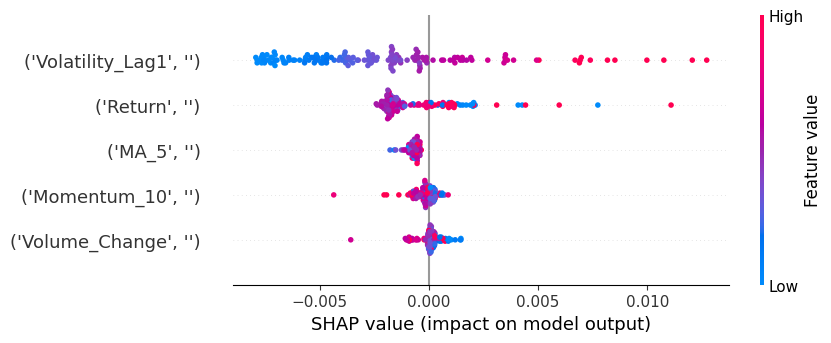

In [ ]:
# Show the global impact of all features
shap.plots.beeswarm(shap_values)


The SHAP beeswarm plot illustrates the global importance of each feature in the XGBoost model used to predict next-day volatility for Apple stock. Among all input variables, the previous day's volatility (Volatility_Lag1) had the highest influence on the model's predictions. Specifically, higher past volatility (shown in red) consistently pushed the predicted risk higher, while lower past volatility (blue) pulled the prediction downward — reflecting the well-known phenomenon of volatility clustering in financial markets. Daily returns (Return) also showed meaningful but less dominant influence; sharp price changes slightly adjusted the predicted risk level depending on their direction and magnitude. Other features such as the 5-day moving average (MA_5) and 10-day momentum (Momentum_10) contributed modestly by helping the model capture short-term price trends, while volume changes (Volume_Change) had minimal but occasionally non-negligible impact. This interpretability confirms that the model relies on economically meaningful signals, aligning with domain knowledge and supporting its use in risk-aware decision-making.